In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r sample_data

!cp "/content/drive/MyDrive/yoga_dataset.zip" "/content/" >null
!unzip -n "/content/yoga_dataset.zip" -d "/content/" >null

!cp "/content/drive/MyDrive/Yoga82.zip" "/content/" >null
!unzip -n "/content/Yoga82.zip" -d "/content/" >null

!rm null yoga_dataset.zip Yoga82.zip

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import LeakyReLU, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_dir = '/content/DATASET/TRAIN' 
test_dir = '/content/DATASET/TEST'

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale =1./255,
                                 validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (224,224),
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical',
                                                    batch_size = 16,
                                                   subset = 'training')
validation_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                       target_size = (224,224),
                                                       color_mode = 'rgb',
                                                       class_mode = 'categorical',
                                                       batch_size = 16,
                                                       subset = 'validation')

Found 866 images belonging to 5 classes.
Found 92 images belonging to 5 classes.


In [ ]:
model = tf.keras.Sequential()
model.add(VGG19(include_top = False,weights = 'imagenet',input_shape= (224,224,3)))
model.add(Flatten())
model.add(Dense(5,activation = 'softmax'))
optimizer = Adam(learning_rate = 0.0001)
model.compile(loss = "categorical_crossentropy",optimizer = optimizer,metrics = ['accuracy'])
epochs = 25
batch_size = 16

model.summary()
history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator)

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 5)                 125445    
                                                                 
Total params: 20,149,829
Trainable params: 20,149,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
10/55 [====>.........................] - ETA: 21s - loss: 1.6156 - accuracy: 0.3125

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


55/55 [==============================] - 59s 646ms/step - loss: 0.9849 - accuracy: 0.6432 - val_loss: 0.1655 - val_accuracy: 0.9891
Epoch 2/25
55/55 [==============================] - 35s 639ms/step - loss: 0.5000 - accuracy: 0.8476 - val_loss: 0.0391 - val_accuracy: 0.9891
Epoch 3/25
55/55 [==============================] - 34s 610ms/step - loss: 0.3596 - accuracy: 0.8811 - val_loss: 0.0332 - val_accuracy: 0.9891
Epoch 4/25
55/55 [==============================] - 33s 598ms/step - loss: 0.2669 - accuracy: 0.9042 - val_loss: 0.0317 - val_accuracy: 0.9891
Epoch 5/25
55/55 [==============================] - 35s 636ms/step - loss: 0.2266 - accuracy: 0.9249 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 6/25
55/55 [==============================] - 31s 561ms/step - loss: 0.1787 - accuracy: 0.9411 - val_loss: 0.0207 - val_accuracy: 0.9891
Epoch 7/25
55/55 [==============================] - 32s 585ms/step - loss: 0.1650 - accuracy: 0.9411 - val_loss: 0.0572 - val_accuracy: 0.9891
Epoch 8/25

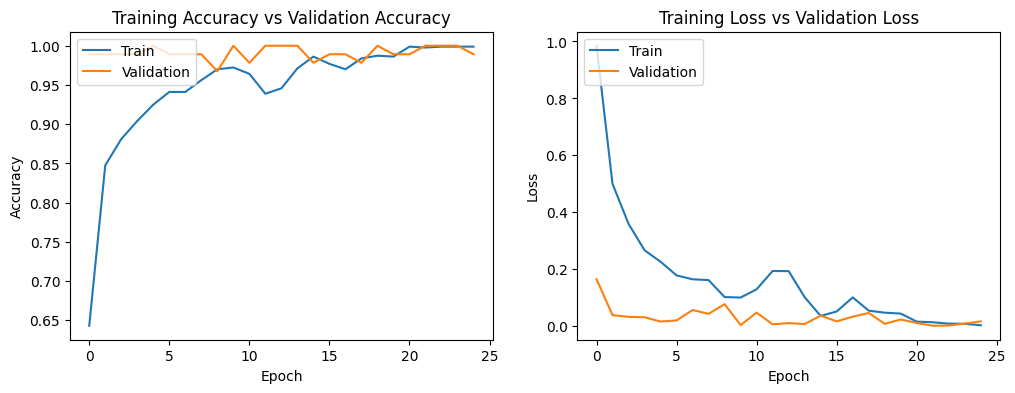

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

6/6 [==============================] - 4s 512ms/step - loss: 0.0173 - accuracy: 0.9891
final train accuracy = 99.88 , validation accuracy = 98.91


In [ ]:
model.save('YogaPoseEstimation.h5')

In [ ]:
model = tf.keras.Sequential()
model.add(VGG19(include_top = False,weights = 'imagenet',input_shape= (224,224,3)))
model.add(Flatten())
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation='softmax'))

model.summary()

optimizer = Adam(learning_rate = 0.0001)
model.compile(loss = "categorical_crossentropy",optimizer = optimizer,metrics = ['accuracy'])
epochs = 25
batch_size = 16

history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 5)                 125445    
                                                                 
Total params: 20,149,829
Trainable params: 20,149,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
55/55 [==============================] - 38s 589ms/step - loss: 1.0647 - accuracy: 0.5993 - val_loss: 0.3054 - val_accuracy: 0.9130
Epoch 2/25
55/55 [=============

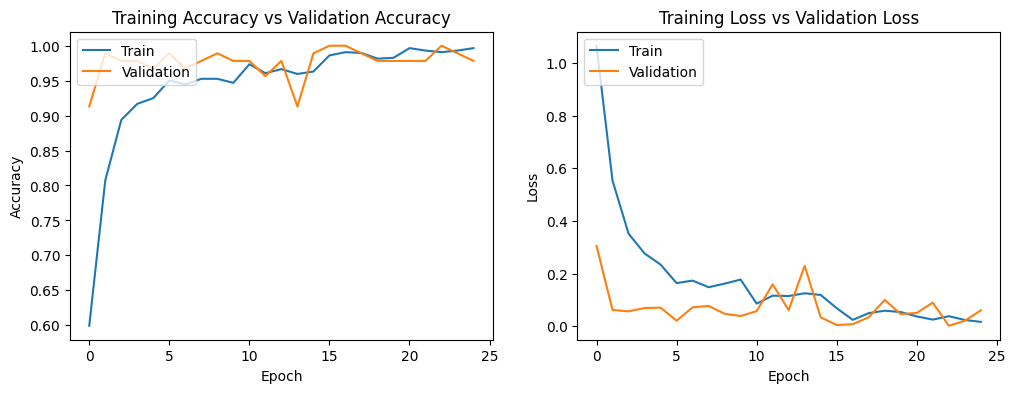

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

6/6 [==============================] - 3s 439ms/step - loss: 0.0607 - accuracy: 0.9783
final train accuracy = 99.77 , validation accuracy = 97.83


In [ ]:
model.save('HumanPoseEstimation.h5')

# For second dataset

In [ ]:
# import os
# import shutil
# import random

# parent_folder = "/content/Yoga82"

# for foldername, subfolders, filenames in os.walk(parent_folder):
#     if len(filenames) < 300 or len(filenames) > 400:
#         print("Deleting folder:", foldername)
#         shutil.rmtree(foldername)

# train_folder = os.path.join(parent_folder, "TRAIN")
# os.makedirs(train_folder, exist_ok=True)

# test_folder = os.path.join(parent_folder, "TEST")
# os.makedirs(test_folder, exist_ok=True)

# subfolders = [os.path.join(parent_folder, f) for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

# # Iterate over the subfolders
# for subfolder in subfolders:

#     subfolder_train = os.path.join(train_folder, os.path.basename(subfolder))
#     os.makedirs(subfolder_train, exist_ok=True)

#     subfolder_test = os.path.join(test_folder, os.path.basename(subfolder))
#     os.makedirs(subfolder_test, exist_ok=True)

#     files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]

#     random.shuffle(files)

#     for i, file_path in enumerate(files):
#         if i < len(files) * 0.8:
#             shutil.copy(file_path, os.path.join(subfolder_train, os.path.basename(file_path)))
#         else:
#             shutil.copy(file_path, os.path.join(subfolder_test, os.path.basename(file_path)))


Deleting folder: /content/Yoga82


In [ ]:
train_dir = '/content/Yoga82/TRAIN' 
test_dir = '/content/Yoga82/TEST'

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale =1./255,
                                 validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (224,224),
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical',
                                                    batch_size = 16,
                                                   subset = 'training')
validation_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                       target_size = (224,224),
                                                       color_mode = 'rgb',
                                                       class_mode = 'categorical',
                                                       batch_size = 16,
                                                       subset = 'validation')